**ARIMA model**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
# Sine Dataset (Deterministic)
sine_data = np.sin(np.arange(0,1000,.01))

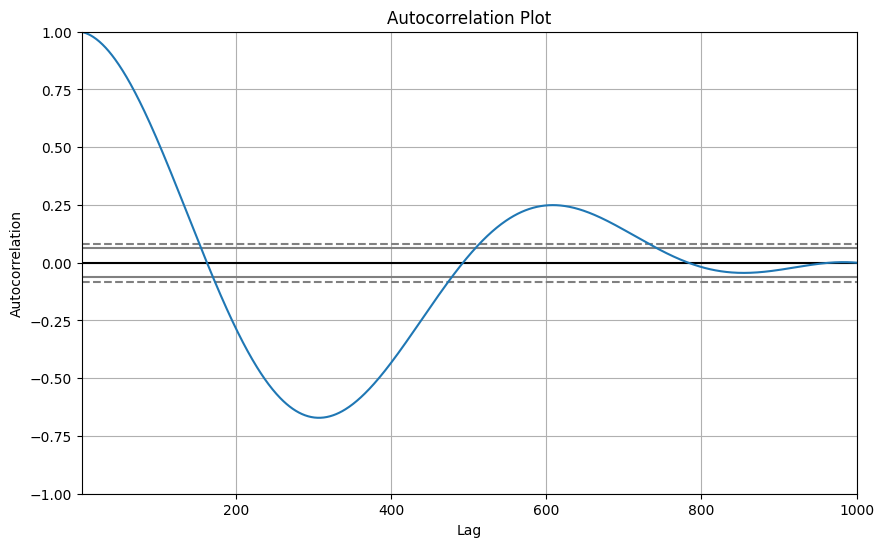

<Figure size 1000x600 with 0 Axes>

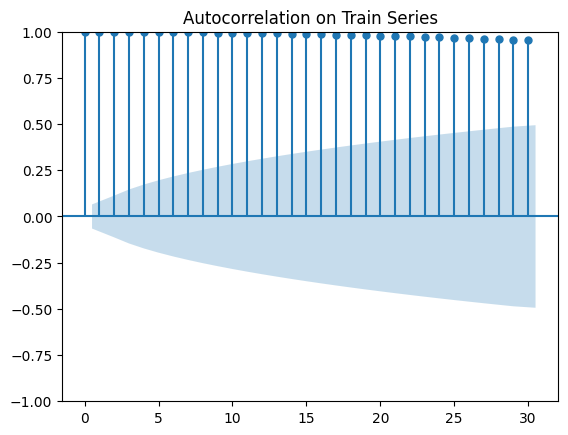

<Figure size 1000x600 with 0 Axes>

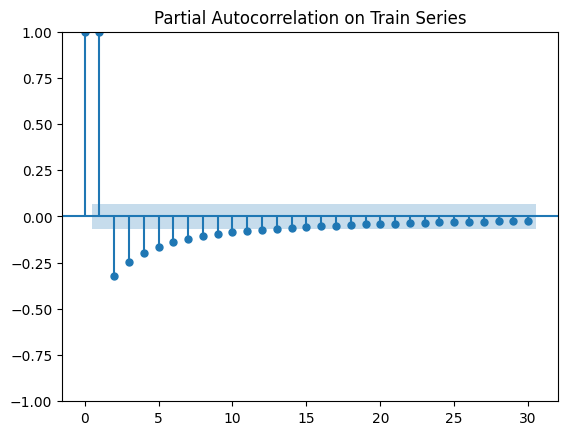

In [11]:
TS = sine_data

# First 1000 data points
time_series = TS[0:1000]

# Autocorrelation plot for TS
plt.figure(figsize=(10, 6))
autocorrelation_plot(time_series)
plt.title("Autocorrelation Plot")
plt.show()

# train and test sets of TS
train_size = int(len(time_series) * 0.9)
train_series = time_series[:train_size]
test_series = time_series[train_size:]

# Autocorrelation and Partial Autocorrelation plots for the train series
plt.figure(figsize=(10, 6))
plot_acf(train_series, title="Autocorrelation on Train Series")
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(train_series, title="Partial Autocorrelation on Train Series")
plt.show()

In [15]:
# Augmented Dickey-Fuller test to check stationarity
adf_test = adfuller(train_series)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
for key, value in adf_test[4].items():
    print(f'Critical Value ({key}): {value}')

if adf_test[1] < 0.05:
    print("Series is stationary.")
else:
    print("Series is not stationary.")

# the ARIMA model
model = ARIMA(train_series, order=(2, 1, 0))
arima_fit = model.fit()

# the summary of the ARIMA model
print(arima_fit.summary())


ADF Statistic: -81749020668556.06
p-value: 0.0
Critical Value (1%): -3.4377858660487277
Critical Value (5%): -2.86482248517442
Critical Value (10%): -2.5685178285796555
Series is stationary.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  900
Model:                 ARIMA(2, 1, 0)   Log Likelihood                2985.624
Date:                Sat, 23 Dec 2023   AIC                          -5965.249
Time:                        22:35:33   BIC                          -5950.845
Sample:                             0   HQIC                         -5959.746
                                - 900                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       8.524e-07      1.505   5.67e-07      1.000      -2.949       2.949
ar.L2       8.495e-07      1.507   5.64e-07      1.000      -2.953       2.953
sigma2         0.0002   1.72e-05      8.814      0.0

Series is stationary as indicated by the extremely negative ADF statistic and a p-value of 0.0, so null hypothesis of a unit root can be rejected. The warning Non-stationary starting autoregressive parameters found. Using zeros as starting parameters suggests that initial guess for AR parameters was non-stationary, and thus, zeros were used instead. It's standard procedure in some implementations of ARIMA when the initial parameters do not meet stationarity requirements. Coefficients for ar.L1 and ar.L2 are extremely small, and their p-values are 1.0. So they are not significantly different from zero that is why AR(2) component not contributing much to the model. The Log Likelihood, AIC (Akaike Information Criterion), BIC (Bayesian Information Criterion), and HQIC (Hannan-Quinn Information Criterion) values are provided, but without a comparison model, their absolute values are less informative. Lower AIC, BIC, and HQIC values generally indicate a better model fit. The Ljung-Box test and Jarque-Bera test results indicate potential issues. The Ljung-Box test has a p-value close to 0, suggesting that there is still autocorrelation in the residuals. The Jarque-Bera test also indicates that residuals might not be normally distributed.

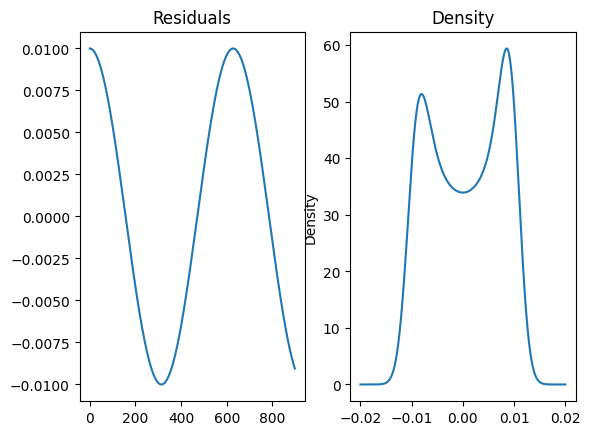

In [17]:
residuals = arima_fit.resid[1:]
residuals = pd.Series(residuals)
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

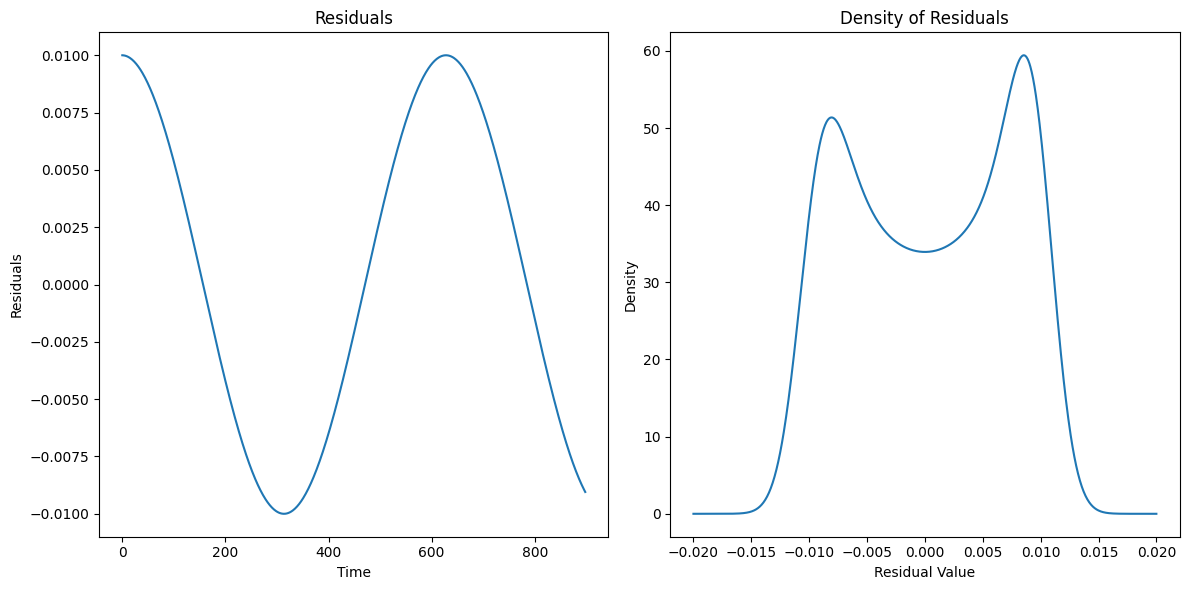

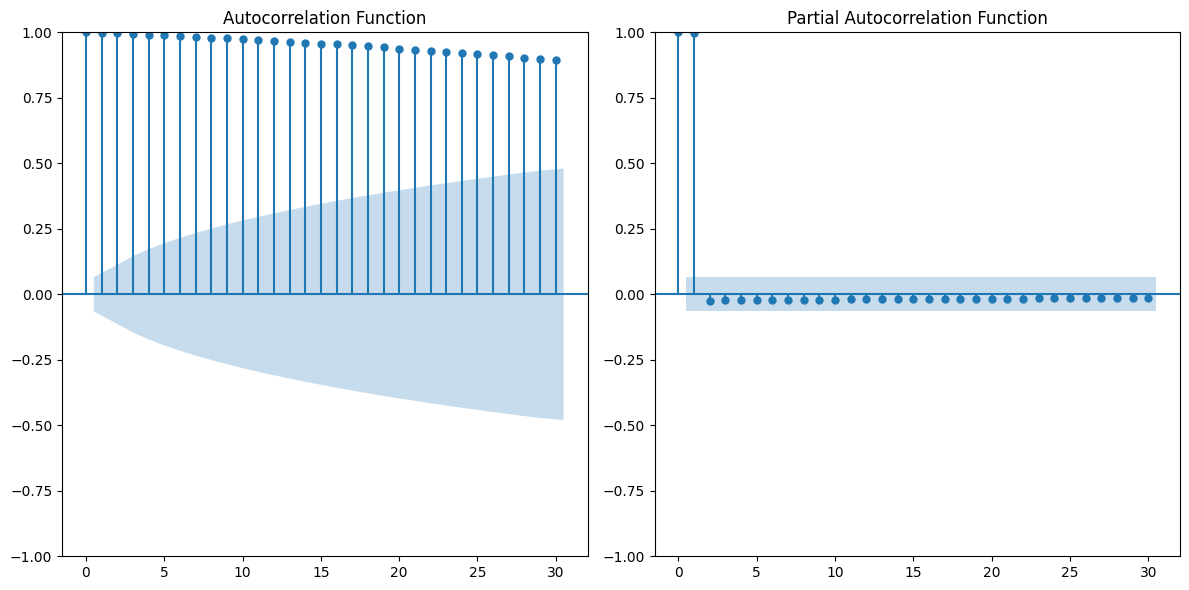

In [18]:
# Residuals
residuals = pd.Series(arima_fit.resid[1:])

# Residuals density subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot of residuals
residuals.plot(title='Residuals', ax=ax[0])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Residuals')

# Kernel Density Estimate plot of residuals
residuals.plot(kind='kde', title='Density of Residuals', ax=ax[1])
ax[1].set_xlabel('Residual Value')
ax[1].set_ylabel('Density')
plt.tight_layout()
plt.show()

# Plot Autocorrelation and Partial Autocorrelation of residuals
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Autocorrelation function (ACF) plot
plot_acf(residuals, ax=axes[0])
axes[0].set_title('Autocorrelation Function')

# Partial autocorrelation function (PACF) plot
plot_pacf(residuals, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

**Analysis:**

The time plot of residuals fluctuates around zero without clear patterns <- it's a good sign. But oscillation suggests there may be some periodic component that not was captured by model.

Residuals have a 'normalish' distribution. Not normal, but 'normalish' due to  deviation indicated by the slight bimodality.

ACF Plot has significant autocorrelation at many lags, which shouldnt be the case for good ARIMA residuals. It means model dont capturing all temporal dependencies in data.

PACF Plot plot has significant spike at lag 0 and quickly drops. It's ok because PACF at lag 0 is always 1. The rest of lags are non-significant. It means thst additional AR not necessary.



SARIMA would be more appropriate.


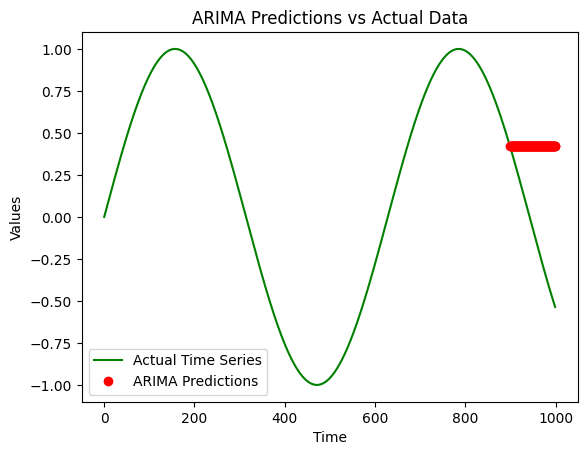

In [20]:
# future values
predictions = arima_fit.forecast(len(test_series))

# Plot of test series predictions
test_points = [None]*len(train_series) + list(predictions)

# Actual TS plot
plt.plot(time_series, label='Actual Time Series', color='green')

# Predicted points plot
plt.plot(test_points, label='ARIMA Predictions', color='red', linestyle='none', marker='o')

# Differentiation of actual and predicted values
plt.legend()


plt.title('ARIMA Predictions vs Actual Data')
plt.xlabel('Time')
plt.ylabel('Values')


plt.show()